In [43]:
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src import AICITY2023TRACK5,readDataFrame
import numpy as np
import matplotlib.pyplot as plt

import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
import tqdm
import seaborn as sns
import torch

In [80]:
DATA_DIRECTORY = os.path.join(os.path.dirname(os.getcwd()),"data")
TRAIN_DATA_DIRECTORY = os.path.join(DATA_DIRECTORY,"aicity2023_track5",)
TEST_DATA_DIRECTORY = os.path.join(DATA_DIRECTORY,"aicity2023_track5_test")

VIDEO_TRAIN_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"videos")
VIDEO_TEST_DIRECTORY = os.path.join(TEST_DATA_DIRECTORY, "videos")
 

IMAGE_TRAIN_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"trainImages")
IMAGE_VAL_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"validationImages")
IMAGE_TEST_DIRECTORY = os.path.join(TEST_DATA_DIRECTORY, "testImages")

LABEL_TRAIN_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"trainLabels")
LABEL_VAL_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"valLabels")


In [93]:
def generateImageFromVideos(root_directory,train_image_directory,val_image_directory,train_data_directory,test= False,test_image_directory = None):
    """
    root_directory - directory containing the videos
    image_directory - location where images will be stored
    """
    if not test:
        train_df,val_df = readDataFrame(train_data_directory)
        train_df_images = train_df["image_path"]
        val_df_images = val_df["image_path"]
        train_df_images = list(train_df_images.astype("string"))
        val_df_images = list(val_df_images.astype("string"))
    
        if not os.path.exists(train_image_directory):
            os.makedirs(train_image_directory)
        if not os.path.exists(val_image_directory):
            os.makedirs(val_image_directory)
    else:
        if not os.path.exists(test_image_directory):
            os.makedirs(test_image_directory)
        
    videos = list(os.listdir(root_directory))
    
    
    for video_path in tqdm.tqdm(videos):
        video = cv2.VideoCapture(os.path.join(root_directory,video_path))
        frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
        for frame in range(int(frames)+2):
            video.set(cv2.CAP_PROP_POS_FRAMES,frame)
            success, image = video.read()
            image_file_name = video_path.split(".")[0] + "_" +f"{frame:03}"
            
            if success:
                if test:
                    cv2.imwrite(os.path.join(test_image_directory,image_file_name) + ".jpeg",image)
                else:
                    if image_file_name + ".jpeg" in val_df_images:

                        cv2.imwrite(os.path.join(val_image_directory,image_file_name) + ".jpeg",image)
                    else:
                        cv2.imwrite(os.path.join(train_image_directory,image_file_name) + ".jpeg",image)

In [94]:
generateImageFromVideos(VIDEO_TEST_DIRECTORY,None,None,None,test=True,test_image_directory=IMAGE_TEST_DIRECTORY)

100%|█████████████████████████████████████████████████████████████| 100/100 [31:50<00:00, 19.10s/it]


In [48]:
generateImageFromVideos(VIDEO_TRAIN_DIRECTORY,IMAGE_TRAIN_DIRECTORY,IMAGE_VAL_DIRECTORY,TRAIN_DATA_DIRECTORY)

100%|█████████████████████████████████████████████████████████████| 100/100 [31:57<00:00, 19.17s/it]


In [49]:
IPython.display.Video("../data/aicity2023_track5/videos/022.mp4",width=700)

In [50]:
def generateLabelsUtilFunction(df,labelDirectory):
    
    unique_image_path = df["image_path"].unique()
    
    for image_path in tqdm.tqdm(unique_image_path):
        detected_objects = df[df["image_path"] == image_path]
        file_path = os.path.join(labelDirectory,image_path.split(".")[0])
        selected_variables = detected_objects[["category","normalized_center_x","normalized_center_y","normalized_width","normalized_height"]]
        selected_variables.to_csv(f'{file_path}.txt', header=False, index=False, sep=' ',)

In [53]:
def generateLabels(trainDataDirectory,trainLabelDirectory,valLabelDirectory):
    """
    trainDataDirectory - training directory
    labelDirectory - location where labels will be stored
    """
    if not os.path.exists(trainLabelDirectory):
        os.makedirs(trainLabelDirectory)
    
    if not os.path.exists(valLabelDirectory):
        os.makedirs(valLabelDirectory)
    
    train_df,val_df = readDataFrame(trainDataDirectory)
    
    generateLabelsUtilFunction(train_df,trainLabelDirectory)
    generateLabelsUtilFunction(val_df,valLabelDirectory)    

In [54]:
generateLabels(TRAIN_DATA_DIRECTORY,LABEL_TRAIN_DIRECTORY,LABEL_VAL_DIRECTORY)

100%|█████████████████████████████████████████████████████████| 1563/1563 [00:01<00:00, 1293.67it/s]


In [55]:
train_df,val_df = readDataFrame(TRAIN_DATA_DIRECTORY)

In [56]:
def add_bbox_Image_yolo_format(image,bbounding_box_data):
    """
    This is the function when the bounding box is not normalized and contains
    the top and the bottom corner
    """
    font = cv2.FONT_HERSHEY_TRIPLEX
    fontScale = 1.5
    fontColor = (0, 0, 255)
    
    for index,bbounding_box in bbounding_box_data.iterrows():
        center_point = (bbounding_box["normalized_center_x"] * 1920,bbounding_box["normalized_center_y"] * 1080)
        widthHeight = (bbounding_box["normalized_width"] * 1920 // 2 ,  bbounding_box["normalized_height"] * 1080 // 2)
        start_point = (int(center_point[0] - widthHeight[0]),int(center_point[1] - widthHeight[1]))
        end_point =(int(center_point[0] + widthHeight[0]),int(center_point[1] + widthHeight[1]))    
        cv2.rectangle(image,start_point,end_point,color=(0,255,0), thickness=2)
        class_text = str(bbounding_box["category"])
        class_text_location = (start_point[0] + 5,start_point[1]+10)
        cv2.putText(image,class_text,class_text_location,font,fontScale,fontColor)
        
    return image

In [57]:
def add_bbox_Image(image,bbounding_box_data):
    """
    This is the function when the bounding box is not normalized and contains
    the top and the bottom corner
    """
    font = cv2.FONT_HERSHEY_TRIPLEX
    fontScale = 1.5
    fontColor = (0, 0, 255)
        
    for index,bbounding_box in bbounding_box_data.iterrows():
        start_point = (bbounding_box["bb_left"],bbounding_box["bb_top"])
        end_point = (bbounding_box["bb_width"]+start_point[0],bbounding_box["bb_height"]+start_point[1])
        cv2.rectangle(image,start_point,end_point,color=(0,255,0), thickness=2)
        class_text = str(bbounding_box["category"])
        class_text_location = (start_point[0] + 5,start_point[1]+10)
        cv2.putText(image,class_text,class_text_location,font,fontScale,fontColor)
        
    return image

In [58]:
def viewImage(dataFrame,video_id,frame,Image_train_directory,ViewFunction,viewBoundingBox = False):
    """
    View the Image with and without bounding box
    """
    
    video = dataFrame[dataFrame["video_id"] == video_id]
    image = video[video["frame"] == frame]
    if(len(image) != 0): 
        
        img = cv2.imread(os.path.join(Image_train_directory,image.iloc[0]["image_path"]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(viewBoundingBox):
            img = ViewFunction(img,image)
        plt.imshow(img)
    else:
        print("This frame doesn't exist please enter the valid one from")
        print(image["frame"])

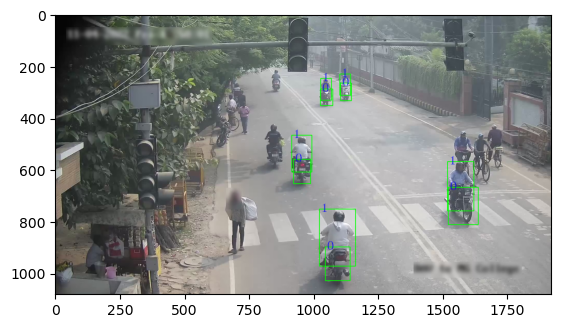

In [60]:
viewImage(train_df,100,2,IMAGE_TRAIN_DIRECTORY,add_bbox_Image_yolo_format,True)

# Exploratory Data Analysis

#### Distribution of the categories

In [72]:
width = []
height = []
label_counts = {i:0 for i in range(7)}
patchDistribution = {}
label_distribution = []
for j in tqdm.tqdm(trainDataset):
    images,labels = j["images"],j["labels"]
    if len(images) not in patchDistribution:
        patchDistribution[len(images)] = 1
    else:
        patchDistribution[len(images)] += 1
    for i in range(len(images)):
        height.append(images[i].shape[0])
        width.append(images[i].shape[1])
        label_counts[labels[i]] += 1
        label_distribution.append(labels[i])

100%|████████████████████████████████████████████████████████| 14062/14062 [02:04<00:00, 113.03it/s]


As it can be seen from the below graph that the highest number of width has the size of below 50 and the height has the size which mostly lies in the range from 50 to 100 thus if we are to resize the image the best width will be somewhere around 60-70 and best height will be 100-120

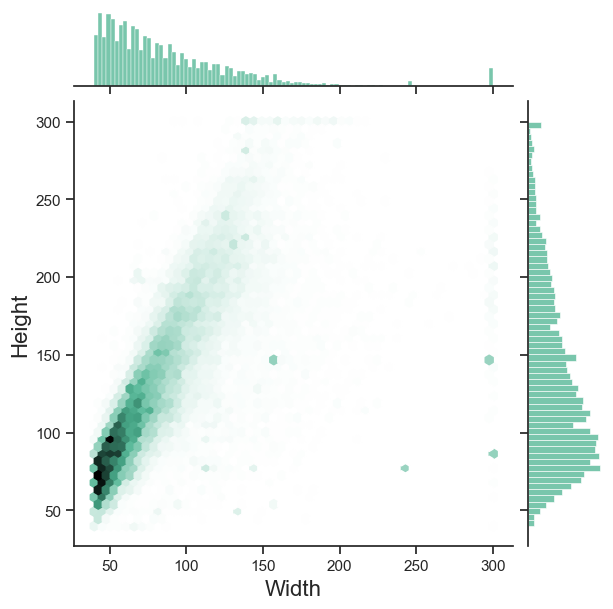

In [73]:
sns.set_theme(style="ticks")
x = width
y = height
bins = np.linspace(0, 300, 300)
x = np.digitize(x, bins)
y = np.digitize(y,bins)
ax = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
ax.set_axis_labels("Width", 'Height', fontsize=16)
plt.show()

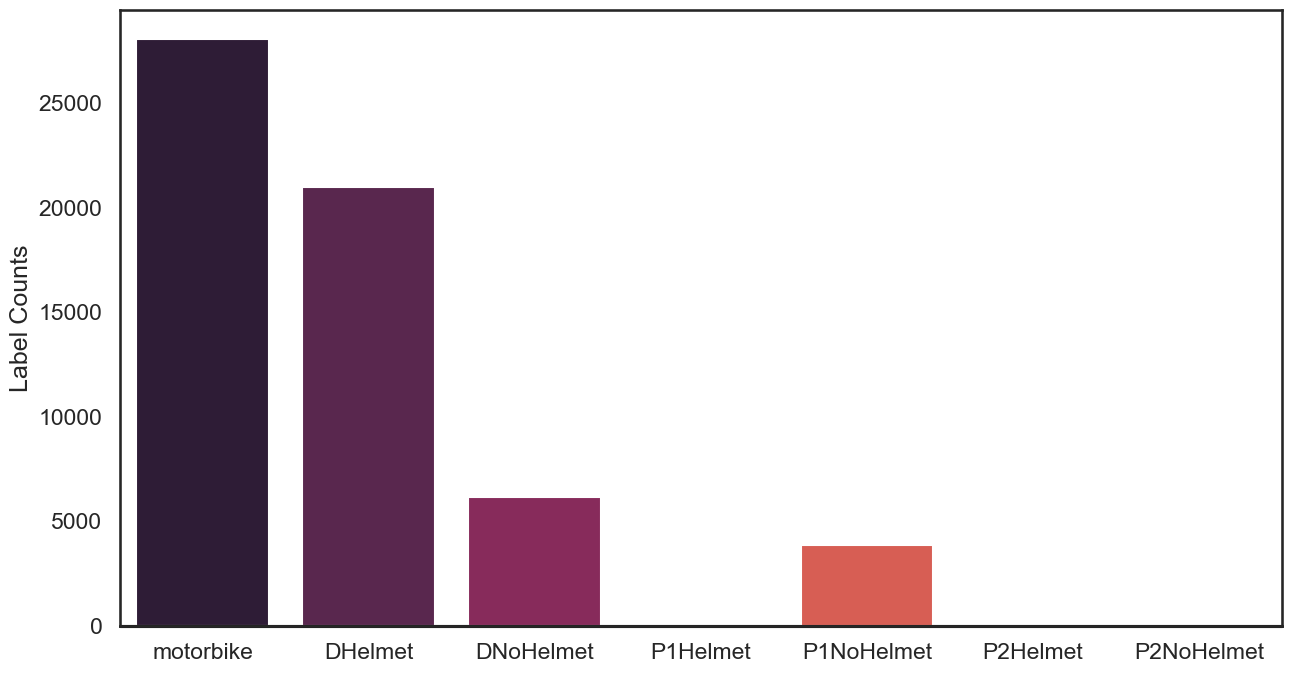

In [74]:
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

f, ax1 = plt.subplots(1, 1, figsize=(15, 8), sharex=True)

data = list(label_counts.keys())
data_value = list(label_counts.values())
data_labels = [trainDataset.labelsToClasses[i] for i in data]

g = sns.barplot(x=data, y=data_value, palette="rocket")
g.set_xticklabels(data_labels)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Label Counts")
plt.show()


As it can be seen from the above graph that the classes are not distributed evenly and is biased with more number of classes of DHelmet and motorbike

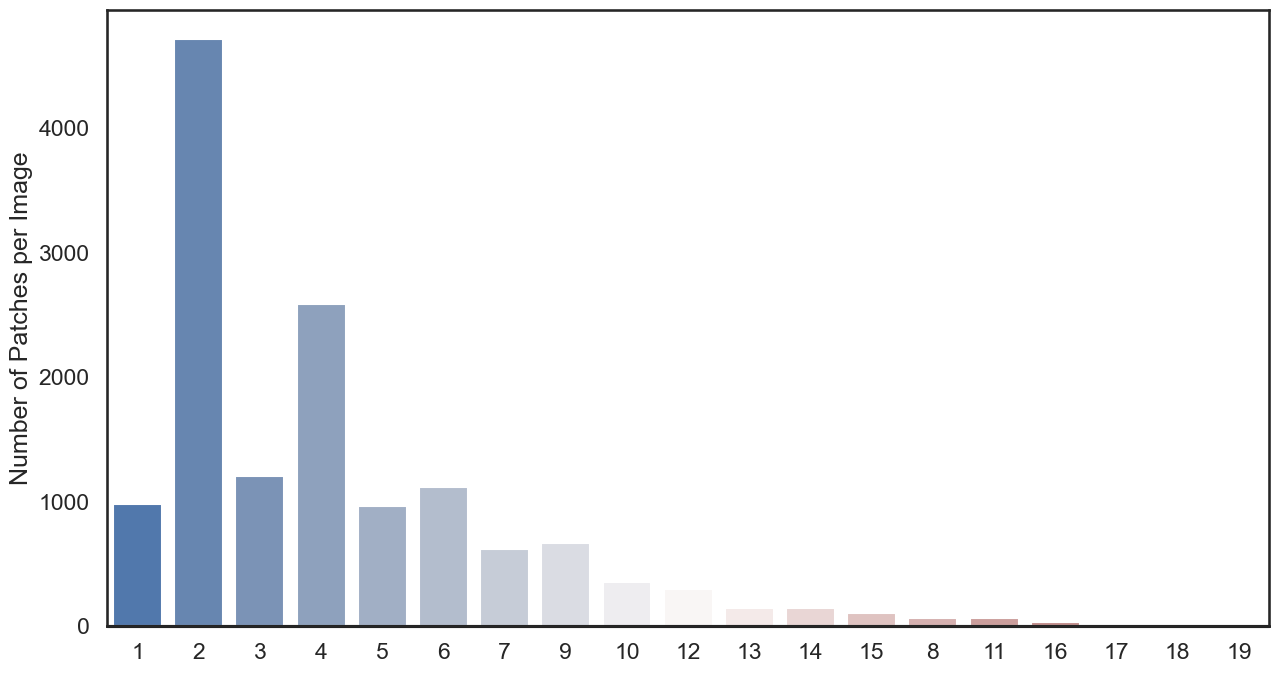

In [75]:
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(15, 8), sharex=True)


data = list(patchDistribution.keys())
data_value = list(patchDistribution.values())

g= sns.barplot(x=data, y=data_value, palette="vlag")
g.set_xticklabels(data)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Number of Patches per Image")
plt.show()

As it can be seen from the above figure that most of the images containes just 2-4 bounding boxes

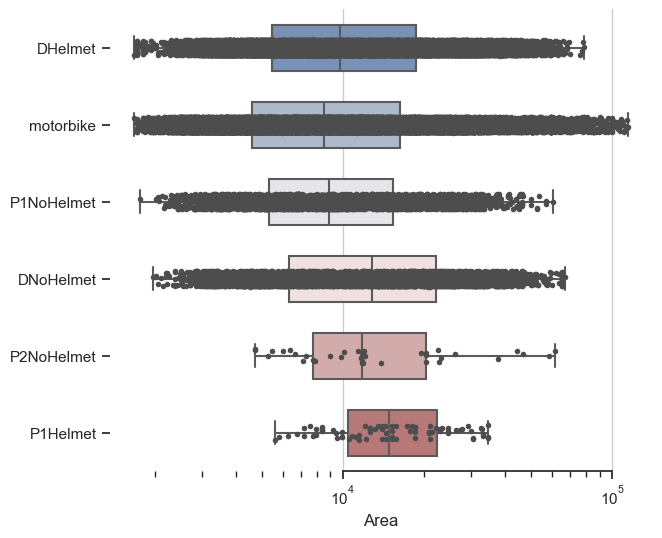

In [76]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

planets = sns.load_dataset("planets")

df = pd.DataFrame([np.array(width)*np.array(height),label_distribution])
df = df.T
df.columns = ["Area","categories"]
df["category_names"] = [trainDataset.labelsToClasses[i] for i in label_distribution]

sns.boxplot(x="Area", y="category_names", data=df,
            whis=[0, 100], width=.6, palette="vlag")

sns.stripplot(x="Area", y="category_names", data=df,
              size=4, color=".3", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

As it can be seen from the above graph that area distribution for most of the classes is approximately similary except of p2Nohelmet and p1Helmet